# CONVOLUTIONAL NEURAL NETWORK WITH CUSTOM DATA

In [1]:
import os
import numpy as np
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
%matplotlib inline  
print ("Packages loaded")

Packages loaded


# LOAD DATA

In [13]:
# Load them!
cwd = os.getcwd()
loadpath = cwd + "/data/custom_data.npz"
l = np.load(loadpath)

# See what's in here
print (l.files)

# Parse data
trainimg = l['trainimg']
trainlabel = l['trainlabel']
testimg = l['testimg']
testlabel = l['testlabel']
imgsize = l['imgsize']
categories = l['categories']
use_gray = l['use_gray']
ntrain = trainimg.shape[0]
nclass = trainlabel.shape[1]
dim    = trainimg.shape[1]
ntest  = testimg.shape[0]
print ("%d train images loaded" % (ntrain))
print ("%d test images loaded" % (ntest))
print ("%d dimensional input" % (dim))
print ("Image size is %s" % (imgsize))
print ("%d classes" % (nclass))
tf.disable_eager_execution()

['trainimg', 'trainlabel', 'testimg', 'testlabel', 'imgsize', 'use_gray', 'categories']
495 train images loaded
330 test images loaded
4096 dimensional input
Image size is [64 64]
5 classes


In [14]:
device_type = "/gpu:1"

# DEFINE NETWORK

In [15]:
with tf.device(device_type): # <= This is optional
    tf.set_random_seed(0)
    n_input  = dim
    n_output = nclass
    if use_gray:
        weights  = {
            'wc1': tf.Variable(tf.random_normal([5, 5, 1, 128], stddev=0.1)),
            'wc2': tf.Variable(tf.random_normal([5, 5, 128, 128], stddev=0.1)),
            'wd1': tf.Variable(tf.random_normal(
                    [(int)(imgsize[0]/4*imgsize[1]/4)*128, 128], stddev=0.1)),
            'wd2': tf.Variable(tf.random_normal([128, n_output], stddev=0.1))
        }
    else:
        weights  = {
            'wc1': tf.Variable(tf.random_normal([5, 5, 3, 128], stddev=0.1)),
            'wc2': tf.Variable(tf.random_normal([5, 5, 128, 128], stddev=0.1)),
            'wd1': tf.Variable(tf.random_normal(
                    [(int)(imgsize[0]/4*imgsize[1]/4)*128, 128], stddev=0.1)),
            'wd2': tf.Variable(tf.random_normal([128, n_output], stddev=0.1))
        }
    biases   = {
        'bc1': tf.Variable(tf.random_normal([128], stddev=0.1)),
        'bc2': tf.Variable(tf.random_normal([128], stddev=0.1)),
        'bd1': tf.Variable(tf.random_normal([128], stddev=0.1)),
        'bd2': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }
    
    def conv_basic(_input, _w, _b, _keepratio, _use_gray):
        # INPUT
        if _use_gray:
            _input_r = tf.reshape(_input, shape=[-1, imgsize[0], imgsize[1], 1])
        else:
            _input_r = tf.reshape(_input, shape=[-1, imgsize[0], imgsize[1], 3])
        # CONVOLUTION LAYER 1
        _conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(_input_r
            , _w['wc1'], strides=[1, 1, 1, 1], padding='SAME'), _b['bc1']))
        _pool1 = tf.nn.max_pool(_conv1, ksize=[1, 2, 2, 1]
            , strides=[1, 2, 2, 1], padding='SAME')
        _pool_dr1 = tf.nn.dropout(_pool1, _keepratio)
        # CONVOLUTION LAYER 2
        _conv2 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(_pool_dr1
            , _w['wc2'], strides=[1, 1, 1, 1], padding='SAME'), _b['bc2']))
        _pool2 = tf.nn.max_pool(_conv2, ksize=[1, 2, 2, 1]
            , strides=[1, 2, 2, 1], padding='SAME')
        _pool_dr2 = tf.nn.dropout(_pool2, _keepratio)
        # VECTORIZE
        _dense1 = tf.reshape(_pool_dr2
                             , [-1, _w['wd1'].get_shape().as_list()[0]])
        # FULLY CONNECTED LAYER 1
        _fc1 = tf.nn.relu(tf.add(tf.matmul(_dense1, _w['wd1']), _b['bd1']))
        _fc_dr1 = tf.nn.dropout(_fc1, _keepratio)
        # FULLY CONNECTED LAYER 2
        _out = tf.add(tf.matmul(_fc_dr1, _w['wd2']), _b['bd2'])
        # RETURN
        out = {
            'input_r': _input_r, 'conv1': _conv1, 'pool1': _pool1
            , 'pool1_dr1': _pool_dr1, 'conv2': _conv2, 'pool2': _pool2
            , 'pool_dr2': _pool_dr2, 'dense1': _dense1, 'fc1': _fc1
            , 'fc_dr1': _fc_dr1, 'out': _out
        }
        return out
print ("NETWORK READY")

NETWORK READY


# DEFINE FUNCTIONS

In [16]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_output])
keepratio = tf.placeholder(tf.float32)

# Functions! 
with tf.device(device_type): # <= This is optional
    pred = conv_basic(x, weights, biases, keepratio, use_gray)['out']
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred, labels = y))
    WEIGHT_DECAY_FACTOR = 0.0001
    # weight decay regularization
    l2_loss = tf.add_n([tf.nn.l2_loss(v) 
                for v in tf.trainable_variables()])
    cost = cost + WEIGHT_DECAY_FACTOR*l2_loss
    optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
    corr = tf.equal(tf.argmax(pred,1), tf.argmax(y,1)) # Count corrects
    accr = tf.reduce_mean(tf.cast(corr, tf.float32)) # Accuracy
    init = tf.global_variables_initializer()
print ("FUNCTIONS READY")

FUNCTIONS READY


# OPTIMIZE

Epoch: 039/400 cost: 2.545113325
 Training accuracy: 0.937
 Test accuracy: 0.887
43 MISSED


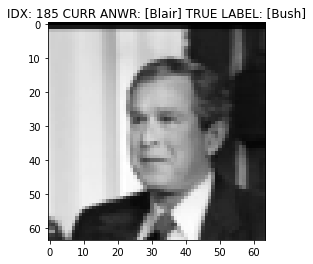

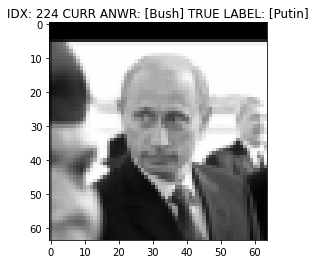

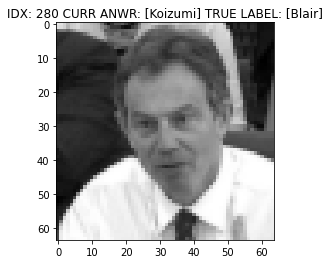

Epoch: 079/400 cost: 1.927726221
 Training accuracy: 1.000
 Test accuracy: 0.897
34 MISSED


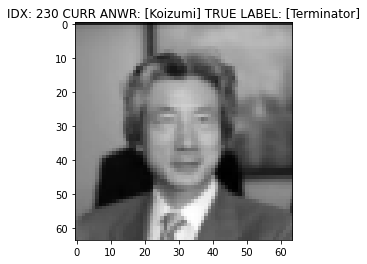

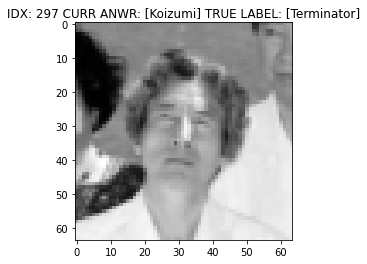

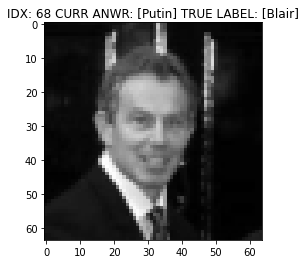

Epoch: 119/400 cost: 1.777909803
 Training accuracy: 1.000
 Test accuracy: 0.909
34 MISSED


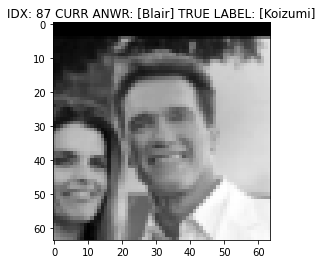

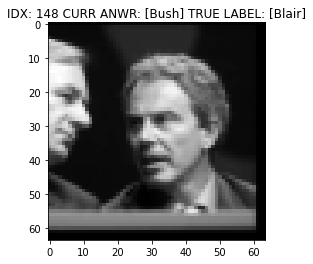

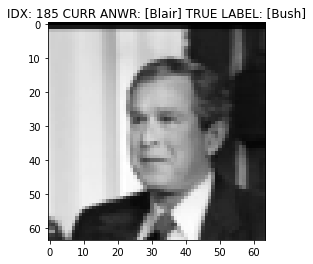

KeyboardInterrupt: 

In [17]:
# Parameters
training_epochs = 400
batch_size      = 100
display_step    = 40

plot_each = 40

# Launch the graph
# sess = tf.Session()
# sess.run(init)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

config.gpu_options.per_process_gpu_memory_fraction = 0.4
        
config.allow_soft_placement=True
sess = tf.Session(config=config)

sess.run(init)



# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(ntrain/batch_size)+1
    # Loop over all batches
    for i in range(num_batch): 
        randidx = np.random.randint(ntrain, size=batch_size)
        batch_xs = trainimg[randidx, :]
        batch_ys = trainlabel[randidx, :]                
        # Fit training using batch data
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys
                                  , keepratio:0.7})
        # Compute average loss
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys
                                , keepratio:1.})/num_batch

    # Display logs per epoch step
    if (epoch+1) % display_step == 0 or epoch == training_epochs-1:
        print ("Epoch: %03d/%03d cost: %.9f" % 
               (epoch+1, training_epochs, avg_cost))
        train_acc = sess.run(accr, feed_dict={x: batch_xs
                                , y: batch_ys, keepratio:1.})
        train_acc=0
        for i in range(num_batch):
            batch_xs=trainimg[i*batch_size:(i+1)*batch_size]
            batch_ys=trainlabel[i*batch_size:(i+1)*batch_size]
            train_acc = train_acc + sess.run(accr, feed_dict={x: batch_xs, y: batch_ys, keepratio:1.})
        print (" Training accuracy: %.3f" % (train_acc/num_batch))
            
        num_test = int(ntest/batch_size) + 1
        test_acc=0
        for i in range(num_test):
            batch_xs=testimg[i*batch_size:(i+1)*batch_size]
            batch_ys=testlabel[i*batch_size:(i+1)*batch_size]
            test_acc = test_acc + sess.run(accr, feed_dict={x: batch_xs, y: batch_ys, keepratio:1.})        

        print (" Test accuracy: %.3f" % (test_acc/num_test))
        
    #PLOT
    if (epoch+1) % plot_each == 0 or epoch == training_epochs-1:
        ntemp = int(ntest/batch_size) + 1
        missidxlist = []
        for ii in range(ntemp):
            iii = np.arange(ii*batch_size, min(ntest, (ii+1)*batch_size))
            feeds = {x: testimg[iii, :], y: testlabel[iii, :], keepratio:1.}
            missidx = np.where(sess.run(corr,feed_dict=feeds) == 0)[0]
            missidxlist = np.concatenate((missidxlist, iii[missidx]))
        nmiss = len(missidxlist)
        print ("%d MISSED" % (nmiss))
        # PLOT MISSCLASSIFIED (UPTO THREE)
        missidxlist = np.random.permutation(missidxlist.astype(int))
        selmissidx = missidxlist[:min(3, nmiss)].astype(int)
        feeds_miss = {x: testimg[selmissidx,:], y: testlabel[selmissidx,:], keepratio:1.}
        pred_miss = sess.run(pred, feed_dict=feeds_miss)
        answ_miss = np.argmax(pred_miss, 1)
        answ_corr = np.argmax(testlabel[selmissidx, :] ,1)
        for idx in range(len(selmissidx)):
            cidx = selmissidx[idx]
            anw = answ_miss[idx]
            ref = answ_corr[idx]
            if use_gray != 0:
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1]))
                plt.imshow(currimg, cmap='gray')
            else :
                currimg = np.reshape(testimg[cidx, :], (imgsize[0], imgsize[1], -1))
                plt.imshow(currimg)
            anw_category = categories[anw]
            ref_category = categories[ref]
            title_string = ("IDX: %d CURR ANWR: [%s] TRUE LABEL: [%s]"
                    % (cidx, anw_category, ref_category))
            plt.title(title_string)
            plt.show()
print ("Optimization Finished!")

# CLOSE SESSION

In [ ]:
sess.close()
print ("Session closed.")